In [569]:
import pandas as pd
dijkstra = pd.read_csv('results/1bag_time_dijkstra_entries.csv', sep=',')
ppo = pd.read_csv('results/1bag_time_ppo_entries.csv', sep=',')
dqn = pd.read_csv('results/1bag_time_dqn_entries.csv', sep=',')

In [570]:
ppo.values[:, 1].mean() / dijkstra.values[:, 1].mean(), dqn.values[:, 1].mean() / dijkstra.values[:, 1].mean()

(1.2812173913043479, 1.2812173913043479)

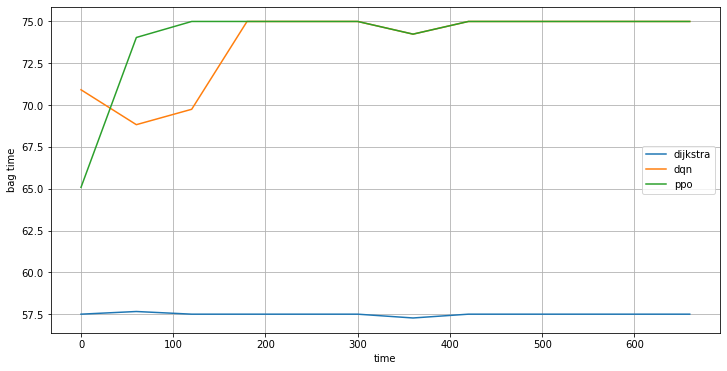

In [573]:
from matplotlib import pyplot as plt

n = 30
plt.figure(figsize=(12, 6))
plot(dijkstra, 'dijkstra')
plot(dqn, 'dqn')
plot(ppo, 'ppo')
plt.grid(True)
plt.xlabel('time')
plt.ylabel('bag time')
plt.legend()
plt.show()

In [574]:
dijkstra_energy = pd.read_csv('results/1energy_consumption_dijkstra_entries.csv', sep=',')
ppo_energy = pd.read_csv('results/1energy_consumption_ppo_entries.csv', sep=',')
dqn_energy = pd.read_csv('results/1energy_consumption_dqn_entries.csv', sep=',')

In [575]:
ppo_energy.values[:, 1].sum() / dijkstra_energy.values[:, 1].sum(), dqn_energy.values[:, 1].sum() / dijkstra_energy.values[:, 1].sum()

(0.8209921434447239, 0.8209921434447239)

In [576]:
def plot(energy, label):
    energy = energy.copy()
    energy['time'] //= n
    energy = energy.groupby('time').agg('mean')
    energy.index *= n
    plt.plot(energy.index, energy['value'], label=label)

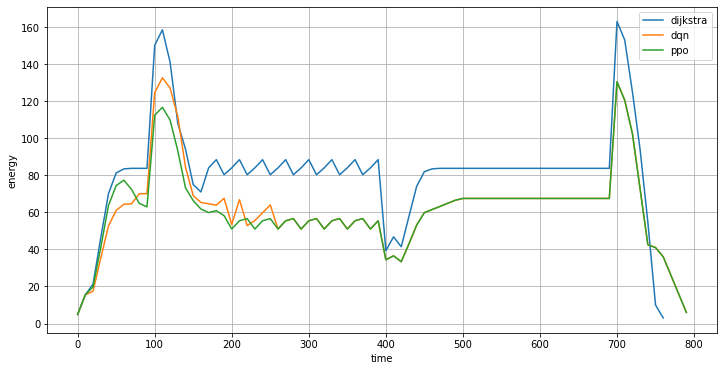

In [577]:
from matplotlib import pyplot as plt

n = 10
plt.figure(figsize=(12, 6))
plot(dijkstra_energy, 'dijkstra')
plot(dqn_energy, 'dqn')
plot(ppo_energy, 'ppo')
plt.grid(True)
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
plt.show()

In [540]:
import json

class Source:
    def __init__(self, source_idx, upstream_idx):
        self.source_idx = source_idx
        self.upstream_idx = upstream_idx
    
    def to_json(self):
        return f'"{self.source_idx}": {{ "upstream_conv": {self.upstream_idx} }}'
    
class Sink:
    def __init__(self, sink_idx):
        self.sink_idx = sink_idx
    
    def to_json(self):
        return f'{self.sink_idx}'

class Diverter:
    def __init__(self, diverter_idx, conveyor_idx, pos, upstream_idx):
        self.diverter_idx = diverter_idx
        self.conveyor_idx = conveyor_idx
        self.pos = pos
        self.upstream_idx = upstream_idx
        
    def to_json(self):
        return f'"{self.diverter_idx}": {{ "conveyor": {self.conveyor_idx}, "pos": {self.pos}, "upstream_conv": {self.upstream_idx} }}'
    
class Conveyor:
    def __init__(self, conveyor_idx, length, quality, upstream_type, upstream_idx, upstream_pos = None):
        self.conveyor_idx = conveyor_idx
        self.length = length
        self.quality = quality
        self.upstream_type = upstream_type
        self.upstream_idx = upstream_idx
        self.upstream_pos = upstream_pos
            
    def to_json(self):
        pos = f', "pos": {self.upstream_pos}' if self.upstream_pos else ''
        return f'"{self.conveyor_idx}": {{ "length": {self.length}, "quality": {self.quality}, "upstream": {{ "type": "{self.upstream_type}", "id": {self.upstream_idx}{pos} }} }}'

def to_jsons(items):
    return [item.to_json() for item in items]
    
def json_topology(sources, sinks, diverters, conveyors):
    sources = to_jsons(sources)
    sinks = to_jsons(sinks)
    diverters = to_jsons(diverters)
    conveyors = to_jsons(conveyors)
    topology_str = f'{{ "topology": {{ "type": "oriented", "sources": {{ {", ".join(sources)} }}, "sinks": [{", ".join(sinks)}], "diverters": {{ {", ".join(diverters)} }}, "conveyors": {{ {", ".join(conveyors)} }} }} }}'
    return json.dumps(json.loads(topology_str), indent=2)

In [558]:
topology = json_topology(
    [Source(0, 0)],
    [Sink(0), Sink(1)],
    [Diverter(0, 0, 20, 1), Diverter(1, 1, 15, 2)],
    [Conveyor(0, 100, 1, 'sink', 0), Conveyor(1, 30, 5, 'sink', 1), Conveyor(2, 10, 5, 'conveyor', 0, 80)]
)
print(topology)

{
  "topology": {
    "type": "oriented",
    "sources": {
      "0": {
        "upstream_conv": 0
      }
    },
    "sinks": [
      0,
      1
    ],
    "diverters": {
      "0": {
        "conveyor": 0,
        "pos": 20,
        "upstream_conv": 1
      },
      "1": {
        "conveyor": 1,
        "pos": 15,
        "upstream_conv": 2
      }
    },
    "conveyors": {
      "0": {
        "length": 100,
        "quality": 1,
        "upstream": {
          "type": "sink",
          "id": 0
        }
      },
      "1": {
        "length": 30,
        "quality": 5,
        "upstream": {
          "type": "sink",
          "id": 1
        }
      },
      "2": {
        "length": 10,
        "quality": 5,
        "upstream": {
          "type": "conveyor",
          "id": 0,
          "pos": 80
        }
      }
    }
  }
}


In [518]:
n = 5
a = 10
l = 15
sources = [Source(i, i) for i in range(n)]
sinks = [Sink(i) for i in range(n)]
diverters = []
for i in range(n - 1):
    for j in range(n):
        diverters.append(Diverter(n + i * n * 2 + j, i, a + 4 * j * a, 2 * n + i * n * 2 + j))
for i in range(1, n):
    for j in range(n):
        diverters.append(Diverter(n + i * n * 2 + j + n, i, 3 * a + 4 * j * a, 3 * n + i * n * 2 + j))
for i in range(n):
    diverters.append(Diverter(i, i, 4 * a * (n + 2), i + n))
conveyors = []
for i in range(n - 1):
    for j in range(n):
        conveyors.append(Conveyor(2 * n + i * n * 2 + j, l, 'conveyor', i + 1, 2 * a + 4 * j * a))
for i in range(1, n):
    for j in range(n):
        conveyors.append(Conveyor(3 * n + i * n * 2 + j, l, 'conveyor', i - 1, 4 * a + 4 * j * a))
for i in range(n):
    conveyors.append(Conveyor(i, 4 * a * (n + 5), 'sink', i))
    conveyors.append(Conveyor(i + n, 5 * l, 'conveyor', (i + 1) % n, 4 * a * (n + 2) - 2 * a))
topology = json_topology(sources, sinks, diverters, conveyors)
print(topology)

{
  "topology": {
    "type": "oriented",
    "sources": {
      "0": {
        "upstream_conv": 0
      },
      "1": {
        "upstream_conv": 1
      },
      "2": {
        "upstream_conv": 2
      },
      "3": {
        "upstream_conv": 3
      },
      "4": {
        "upstream_conv": 4
      }
    },
    "sinks": [
      0,
      1,
      2,
      3,
      4
    ],
    "diverters": {
      "5": {
        "conveyor": 0,
        "pos": 10,
        "upstream_conv": 10
      },
      "6": {
        "conveyor": 0,
        "pos": 50,
        "upstream_conv": 11
      },
      "7": {
        "conveyor": 0,
        "pos": 90,
        "upstream_conv": 12
      },
      "8": {
        "conveyor": 0,
        "pos": 130,
        "upstream_conv": 13
      },
      "9": {
        "conveyor": 0,
        "pos": 170,
        "upstream_conv": 14
      },
      "15": {
        "conveyor": 1,
        "pos": 10,
        "upstream_conv": 20
      },
      "16": {
        "conveyor": 1,
        "pos"